In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

##

In [6]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [11]:
def mediapipe_detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image, results

In [14]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [23]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [27]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame,holistic)
        #print(results)
        
        #draw_landmarks(image,results)
        draw_styled_landmarks(image,results)
         
        cv2.imshow("OpenCV Feed",image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [25]:
draw_styled_landmarks(frame, results)

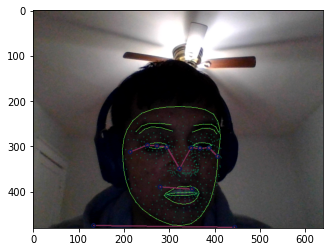

In [26]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))